In [1]:
import matplotlib.pyplot as plt
import pydicom
import os
import numpy as np
import pandas as pd
from skimage import filters
from skimage import measure
import statistics

In [2]:
def mean_pixel_and_slice_location(dataset):
    mean_pixel = np.mean(dataset.pixel_array)
    slice_location = dataset.get('SliceLocation', "(missing)")
    return (mean_pixel, slice_location)

In [3]:
def remove_DSStore(outer_file):
    for inner_file in outer_file:
        if inner_file == '.DS_Store':
            outer_file.remove(inner_file)

In [4]:
os.getcwd()

'/Users/theocohen/Desktop/UNI/4THYR/MPHYS2'

In [5]:
slice_location_array = []
threshold_value_array = []
no_background_threshold_value_array = []
number_less_than_threshold_array = []
filename_array = []

folders = os.listdir('/Users/theocohen/Desktop/UNI/4THYR/MPHYS2/LUNG CT/NSCLC-Radiomics/LUNG1-004/09-24-2006-StudyID-27873/0-20785')
for scan in folders:
    filename_array.append(scan)
    
    path = '/Users/theocohen/Desktop/UNI/4THYR/MPHYS2/LUNG CT/NSCLC-Radiomics/LUNG1-004/09-24-2006-StudyID-27873/0-20785/' + scan
    dataset = pydicom.dcmread(path)
    
    slice_location = dataset.get('SliceLocation', "(missing)")
    slice_location_array.append(slice_location)
    
    pixel_array = dataset.pixel_array
    
    threshold_value = filters.threshold_otsu(pixel_array)
    # Find threshold value for separating foreground and background using Otsu thresholding
   
    threshold_array = np.full(pixel_array.shape, threshold_value)
    bool_array = np.greater(pixel_array, threshold_array)
    # Create boolean array of pixel array values compared to threshold value to display binary image
    # of foreground and background
    
    labels = measure.label(bool_array,background=1)
    # Label each connected component of binary image and create new label array
    
    counts = np.bincount(labels.flatten())  
    # Count number of occurences of each label in label array
    
    background_label = np.argmax(counts)
    # Identify the label number of the background as the bin containing the greatest number
    
    pixel_array_normalized = pixel_array / pixel_array.max()
    # Normalize pixel array between 0 and 1
    
    normalized_threshold_value = filters.threshold_otsu(pixel_array_normalized)
    threshold_value_array.append(normalized_threshold_value)
    
    flat_labels = labels.flatten()
    flat_pixel_array_normalized = pixel_array_normalized.flatten()
    
    flat_pixel_array_normalized_minus_background = flat_pixel_array_normalized[flat_labels != background_label]
    # Removes the background of the CT scan
    # Flattened array of grey scale CT scan left
    
    no_background_threshold_value = filters.threshold_otsu(flat_pixel_array_normalized_minus_background)
    no_background_threshold_value_array.append(no_background_threshold_value)
    median_threshold = statistics.median(no_background_threshold_value_array)
    # Threshold value for image with no background
    
    less_than_threshold_value=flat_pixel_array_normalized_minus_background[flat_pixel_array_normalized_minus_background<=median_threshold]
    number_less_than_threshold = len(less_than_threshold_value)
    number_less_than_threshold_array.append(number_less_than_threshold)
    # Number of pixels with values less than the background value
    
    

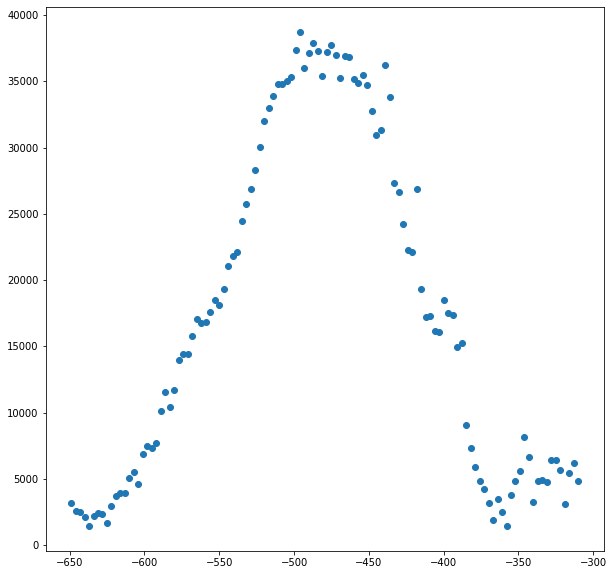

In [6]:
plt.figure(figsize=(10,10))
plt.scatter(slice_location_array, number_less_than_threshold_array)

In [18]:
combined_array = list(zip(filename_array, slice_location_array, number_less_than_threshold_array))
dataframe = pd.DataFrame(combined_array, columns = ['File Name', 'Slice Location','Number < Median Threshold'])

dataframe = dataframe.sort_values(by=['Slice Location'])

maximum = dataframe['Slice Location'].max()

for index, row in dataframe.iterrows():
    if row['Slice Location'] > (maximum - 100):
            dataframe = dataframe.drop(index)
            
print(dataframe['File Name'][dataframe['Number < Median Threshold'].idxmin()])
dataframe

000029.dcm


,File Name,Slice Location,Number < Median Threshold
40,000030.dcm,-649.0,3168
87,000113.dcm,-646.0,2586
78,000112.dcm,-643.0,2533
89,000111.dcm,-640.0,2120
75,000029.dcm,-637.0,1493
...,...,...,...
112,000062.dcm,-424.0,22286
65,000006.dcm,-421.0,22092
103,000061.dcm,-418.0,26858
100,000060.dcm,-415.0,19340


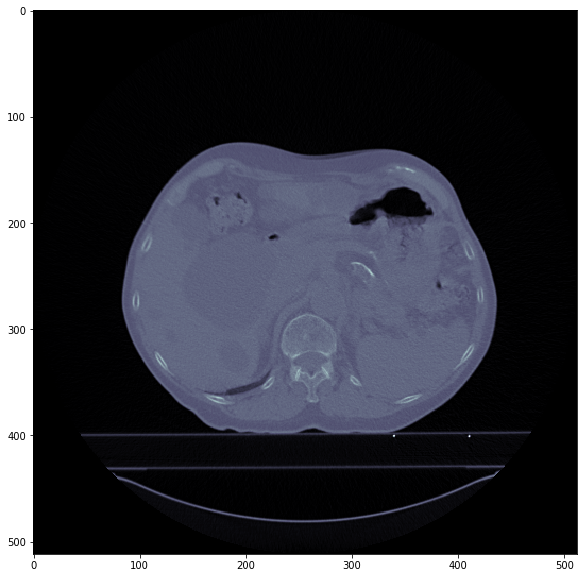

In [19]:
path = '/Users/theocohen/Desktop/UNI/4THYR/MPHYS2/LUNG CT/NSCLC-Radiomics/LUNG1-004/09-24-2006-StudyID-27873/0-20785/000029.dcm'
dataset = pydicom.dcmread(path)
plt.figure(figsize=(10,10))
plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()